In [71]:
library(limma)
library(reshape2)
library(gridExtra)

source("../../evaluation_utils/plots_eda.R")
source("../../evaluation_utils/simulation_func.R")
# source("../../evaluation_utils/filtering/filtering_normalization.R")


# Settings

Parameters set to generate simulated data with 600 samples and 6000 proteins.

In [72]:
generate_metadata <- function(batch_info, mode){

    if (mode == "balanced"){
        # Create batch assignments for each group
        batches <- rep(c("batch1", "batch2", "batch3"), each = 100)
        # Combine batch assignments
        batch_info$condition <- as.factor(c(rep("A", 300), rep("B", 300)))
        batch_info$batch <- as.factor(c(batches[sample(1:300)], batches[sample(1:300)]))

    } else if (mode == "strong_imbalanced") {
        # Strong imbalance
        # Create batch assignments for each group    
        batches_A <- c(rep("batch1", 32), rep("batch2", 28), rep("batch3", 288))
        batches_B <- c(rep("batch1", 8), rep("batch2", 52), rep("batch3", 192))
        # Combine batch assignments
        batch_info$condition <- as.factor(c(rep("A", length(batches_A)), rep("B", length(batches_B))))
        batch_info$batch <- as.factor(c(
            batches_A[sample(1:length(batches_A))], 
            batches_B[sample(1:length(batches_B))]))
    
    } else if(mode == "mild_imbalanced") {
        # Mild imbalance
        # Create batch assignments for each group    
        batches_A <- c(rep("batch1", 36), rep("batch2", 91), rep("batch3", 185))
        batches_B <- c(rep("batch1", 54), rep("batch2", 49), rep("batch3", 185))
        # Combine batch assignments
        batch_info$condition <- as.factor(c(rep("A", length(batches_A)), rep("B", length(batches_B))))
        batch_info$batch <- as.factor(c(
            batches_A[sample(1:length(batches_A))], 
            batches_B[sample(1:length(batches_B))]))
    }
    return(batch_info)

}

In [73]:
workdir <- "/home/yuliya/repos/other/removeBatch/evaluation_data/simulated/"

number_of_runs = 1

mu_1 = 1.45
mu_4 = 1.25

frac_1 = 0.45
frac_7 = 0.15

# number of samples
m = 600

## generate data

In [74]:
check_dirs <- function(workdir){
    if (!dir.exists(workdir)){
        dir.create(workdir)
    }
}

0.5 
0.5[1] "Run number 1"
180 
Number of DE proteins:  2400 
  Number of proteins:  6000 
    batch1     batch2     batch3 
 0.7694931 -0.2761051 -2.3242997 
   batch1    batch2    batch3 
0.1021493 0.4387624 0.8130907 
0.58 
0.42[1] "Run number 1"
162 
Number of DE proteins:  2400 
  Number of proteins:  6000 
    batch1     batch2     batch3 
 0.1863454 -2.3210624  0.7741474 
   batch1    batch2    batch3 
0.1476007 0.2754733 0.9901650 


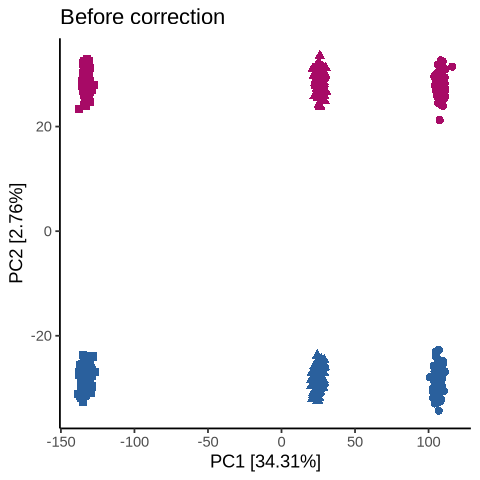

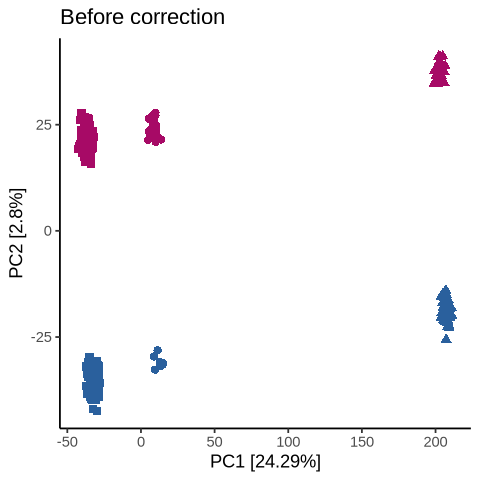

In [75]:
for (mode in c("balanced", #"mild_imbalanced" , 
                "strong_imbalanced"
    )){
    # select random seed
    set.seed(runif(1, 1, 10000))
    sub_path = mode

    # Set directories
    generated_data_directory <- paste0(workdir, sub_path, "/before/intermediate")
    check_dirs(generated_data_directory)

    # Create metadata
    batch_info <- data.frame(file = paste("s", 1:600, sep="."))
    rownames(batch_info) <- batch_info$file
    batch_info <- generate_metadata(batch_info, mode)
    # batch_info %>% group_by(batch, condition) %>%
    #     summarise(n = n()) %>% print()
    
    # Set parameters for simulation
    col_frac_A = length(batch_info[batch_info$condition == "A",]$file) / 600
    col_frac_B = length(batch_info[batch_info$condition == "B",]$file) / 600
    cat(col_frac_A, "\n")
    cat(col_frac_B)


    # Run simulation
    for(j in 1:number_of_runs){
        i = 1  
        print(paste0("Run number ", j))
        set.seed(runif(1, 1, 10000))

        result <- generate_data(
            col_frac_A, col_frac_B,
            frac_1, frac_7,
            mu_1=mu_1, mu_4=mu_4,
            batch_info=batch_info,
            mode_version = mode,
            m = m
        ) %>% as.data.frame()
        
        number_DE <- frac_1*2500*2 + frac_7*1000

        rownames(result) <- c(paste0("prt", 1:length(rownames(result))))
        dim(result)
        cat("Number of DE proteins: ", number_DE, "\n", " Number of proteins: ", nrow(result), "\n")

        # second, add batch effects
        data_with_batch_effects <- add_batch_effect(result, batch_info)

        # Add missing values
        # data_with_batch_effects_missing <- simulateMissingValues(data_with_batch_effects, alpha = 0.2, beta = 0.5)
        # sum(is.na(data_with_batch_effects_missing)) / (nrow(data_with_batch_effects_missing) * ncol(data_with_batch_effects_missing))
        data_with_batch_effects_missing <- data_with_batch_effects


        # #write data for each lab
        # write.table(as.data.frame(data_with_batch_effects_missing[, batch_info[batch_info$batch == "batch1",]$file]) %>% rownames_to_column("rowname"), 
        #             # paste0(generated_data_directory, "/",  j, "_lab_1_intensities_data.tsv"), sep = "\t")
        #             paste0(workdir, sub_path, "/before/lab1/intensities.tsv"), sep = "\t", row.names = FALSE)
        # write.table(batch_info[batch_info$batch == "batch1",] %>% select(file, condition), 
        #             paste0(workdir, sub_path, "/before/lab1/design.tsv"), sep = "\t", row.names = FALSE)

        # write.table(as.data.frame(data_with_batch_effects_missing[, batch_info[batch_info$batch == "batch2",]$file]) %>% rownames_to_column("rowname"),
        #             # paste0(generated_data_directory, "/",  j, "_lab_2_intensities_data.tsv"), sep = "\t")
        #             paste0(workdir, sub_path, "/before/lab2/intensities.tsv"), sep = "\t", row.names = FALSE)
        # write.table(batch_info[batch_info$batch == "batch2",] %>% select(file, condition),
        #             paste0(workdir, sub_path, "/before/lab2/design.tsv"), sep = "\t", row.names = FALSE)

        # write.table(as.data.frame(data_with_batch_effects_missing[, batch_info[batch_info$batch == "batch3",]$file]) %>% rownames_to_column("rowname"),
        #             # paste0(generated_data_directory, "/",  j, "_lab_3_intensities_data.tsv"), sep = "\t")
        #             paste0(workdir, sub_path, "/before/lab3/intensities.tsv"), sep = "\t", row.names = FALSE)
        # write.table(batch_info[batch_info$batch == "batch3",] %>% select(file, condition),
        #             paste0(workdir, sub_path, "/before/lab3/design.tsv"), sep = "\t", row.names = FALSE)

        # # save data without missing values as one file
        # write.table(data_with_batch_effects, paste0(generated_data_directory, "/", j, "_intensities_data.tsv"), sep = "\t")
        # # and data with them as one file
        # write.table(data_with_batch_effects_missing, paste0(generated_data_directory, "/", j, "_intensities_data_missing.tsv"), sep = "\t")
        # # and data without batch effects as one file
        # write.table(result, paste0(generated_data_directory, "/", j, "_intensities_data_no_batch.tsv"), sep = "\t")

        options(repr.plot.width=4, repr.plot.height=4)
        plot <- pca_plot(
            data_with_batch_effects_missing, batch_info,
            title = paste("Before correction"),
            quantitative_col_name = "file", 
            col_col = "condition", shape_col="batch", show_legend=F, cbPalette=c("#a70a66", "#2a609d"))
        print(plot)

    }
    # write batch info
    # write.table(batch_info, paste0(generated_data_directory, "/batch_info.tsv"), sep = "\t")
}